<a href="https://colab.research.google.com/github/aliraein/aliraein/blob/main/LSTM_PTB_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
from google.colab import files
uploaded = files.upload()

Saving test.txt to test.txt
Saving input.txt to input.txt
Saving valid.txt to valid.txt
Saving train.txt to train.txt


In [3]:
import numpy as np
import logging
import time
import math
import datetime
import collections
import matplotlib.pyplot as plt

In [1]:
%tensorflow_version 1.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

TensorFlow 1.x selected.
Found GPU at: /device:GPU:0


In [41]:
### Start your code
#####tf.compat.v1.disable_eager_execution()
class PTBModel(object):
    
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, initializer,dropout_ratio, 
                 clip_norm,learning_rate,inp,target,batch_size):
        #create ops and tensors;
        embedding=tf.get_variable('embedding',shape=(vocab_size, embedding_dim),initializer=initializer,
                                  trainable=True)
#         embedding=tf.compat.v1.get_variable('embedding',shape=(vocab_size, embedding_dim),
#                                             initializer=initializer,trainable=True)
        
        #crashes when input_mode='skip_input' or 'auto_select'
        rnn=tf.contrib.cudnn_rnn.CudnnLSTM(num_layers=num_layers, num_units=hidden_dim, dropout=dropout_ratio,
                                           kernel_initializer=initializer,input_mode='linear_input')
#         rnn=tf.compat.v1.nn.rnn_cell.CudnnLSTM(num_layers=num_layers, num_units=hidden_dim, dropout=dropout_ratio,
#                                            kernel_initializer=initializer,input_mode='linear_input')

#         rnn=tf.contrib.cudnn_rnn.CPULSTM(num_layers=num_layers, num_units=hidden_dim, dropout=dropout_ratio,
#                                            kernel_initializer=initializer,input_mode='linear_input')
        
        dense=tf.layers.Dense(units=vocab_size, kernel_initializer=initializer)
        
        h=tf.get_variable('h',shape=(num_layers,batch_size,hidden_dim),
                          initializer=tf.zeros_initializer,trainable=False)
        c=tf.get_variable('c',shape=(num_layers,batch_size,hidden_dim),
                          initializer=tf.zeros_initializer,trainable=False)
        State=collections.namedtuple('State',['h','c'])
        self._state=State(h=h,c=c)
        y=tf.nn.embedding_lookup(embedding, inp)


        
        y,(h,c)=rnn(y, initial_state=self._state, training=True)

        self._update=State(h=self._state.h.assign(h),c=self._state.c.assign(c))
    
        y=dense(y)

        ##added
        self.y_pred = y
        ##added 

        self._loss=tf.math.reduce_sum(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=target,logits=y))
    
        optimizer=tf.train.GradientDescentOptimizer(learning_rate)
        grad_var=optimizer.compute_gradients(self._loss)
        gradients,variables=zip(*grad_var)
        clipped, global_norm=tf.clip_by_global_norm(gradients, clip_norm)
        grad_var=zip(clipped, variables)
        self._training_op=optimizer.apply_gradients(grad_var)
        
    def run_epoch(self, session, steps, is_training=False):
        session.run({'h':self._state.h.initializer,'c':self._state.c.initializer})
        losses=[]
        fetches={'update':self._update, 'loss':self._loss}
        if is_training:
            fetches['training_op']=self._training_op
        for step in range(steps):
            fetched=session.run(fetches)
            losses.append(fetched['loss'])
        return losses, self.y_pred ###self.y_pred was added
    
    @classmethod
    def instance(cls, model_type='small', vocab_size=10000, clip_norm=5,
                 learning_rate=None, inp=None, target=None):
        return {'small':PTBModel(vocab_size=vocab_size,embedding_dim=200,hidden_dim=200,num_layers=2,
                                 initializer=tf.random_uniform_initializer(minval=-0.1,maxval=0.1),
                                 dropout_ratio=0.,clip_norm=clip_norm,learning_rate=learning_rate,inp=inp,
                                 target=target,batch_size=20),'medium':None,'large':None}.get(model_type,None)
       
    

    
### End


In [42]:
### Start your code
def features_labels(data_array,batch_size,seq_len,batch_first=True):
    if len(data_array.shape) != 1:
        raise ValueError('Expected 1-d data array, ''instead data array shape is {} '.format(data_array.shape))
  
    def fold(used_array):
        shaped_array=np.reshape(used_array,(batch_size,seq_len*steps),order='C')
        
        if batch_first:
            return np.concatenate(np.split(shaped_array,steps,axis=1),axis=0)
        else:
            return np.transpose(shaped_array)

    steps=(data_array.shape[0]-1)//(batch_size*seq_len)
    used=batch_size*seq_len*steps
  
    features=fold(data_array[:used])
    labels=fold(data_array[1:used+1])
  
    Data=collections.namedtuple('Data',['features','labels'])
    return Data(features=features,labels=labels),steps

### End


In [43]:
# ---------------------- set up
start_time=time.time()
logging.basicConfig(level=logging.INFO)
logging.info('date {}'.format(datetime.datetime.now()))
logging.info('device {}'.format(tf.test.gpu_device_name()))
logging.info('TensorFlow vers. {}'.format(tf.__version__))
#assert tf.test.is_gpu_available()

# ----------------- hyper parameters
batch_size=20
seq_len=20
clip_norm=5
learning_rate=1.
decay=0.5
epochs=13
epochs_no_decay=4

## loading the data a little differently 
with open('./train.txt','r') as f1,open('./valid.txt','r') as f2,open('./test.txt','r') as f3:
    seq_train=f1.read().replace('\n','<eos>').split(' ')
    seq_valid=f2.read().replace('\n','<eos>').split(' ')
    #seq_test=f3.read().replace(' ___','')# ##replace('<unk>', '').replace('\n','<eos>')
    seq_test= f3.read().replace('\n','<eos>').split(' ')

seq_train=list(filter(None,seq_train))
seq_valid=list(filter(None,seq_valid))
seq_test=list(filter(None,seq_test)) 

logging.info(seq_train[:10])
logging.info(seq_valid[:10])
logging.info(seq_test[:10])

size_train=len(seq_train)
size_valid=len(seq_valid)
size_test=len(seq_test)
logging.info('size_train {}, size_valid {}, size_test {}'.format(size_train,size_valid,size_test))

vocab_train=set(seq_train)
vocab_valid=set(seq_valid)
vocab_test=set(seq_test)

#assert vocab_valid.issubset(vocab_train)
#assert vocab_test.issubset(vocab_train)
logging.info('vocab_train {}, vocab_valid {}, vocab_test {}'.format(
    len(vocab_train),len(vocab_valid),len(vocab_test)))

vocab_train=sorted(vocab_train)#must have deterministic ordering, so word2id 
                               #dictionary is reproducible across invocations
word2id={w:i for i,w in enumerate(vocab_train)}
id2word={i:w for i,w in enumerate(vocab_train)}


# shape --> (seq_len*steps, batch_size)
#Note tf.contrib.cudnn_rnn.CudnnLSTM requires input tensor to be of shape 
#(seq_len,batch_size,embedding_dim), where as tf.keras.layers.CuDNNLSTM 
#requires input tensor to be of shape (batch_size,seq_len,embedding_dim)
ids_train=np.array([word2id[word] for word in seq_train],copy=False,order='C')
ids_valid=np.array([word2id[word] for word in seq_valid],copy=False,order='C')
ids_test=np.array([word2id[word] for word in seq_test],copy=False,order='C')

data_train,steps_train=features_labels(ids_train,batch_size,seq_len,batch_first=False)
data_valid,steps_valid=features_labels(ids_valid,batch_size,seq_len,batch_first=False)
data_test,steps_test=features_labels(ids_test,batch_size,seq_len,batch_first=False)

# ----------------- configure dataflow graph
tf.reset_default_graph()
# tf.compat.v1.reset_default_graph()

features_placeholder=tf.placeholder(data_train.features.dtype, (None,batch_size))#data_train.features.shape
# tf.compat.v1.disable_eager_execution()
# features_placeholder = tf.compat.v1.placeholder(data_train.features.dtype, (None,batch_size))

labels_placeholder=tf.compat.v1.placeholder(data_train.labels.dtype, (None,batch_size))#data_train.labels.shape

dataset=tf.data.Dataset.from_tensor_slices((features_placeholder, labels_placeholder))

#"An initializable iterator requires you to run an explicit  
#iterator.initializer operation before using it. In exchange for this  
#inconvenience, it enables you to parameterize the definition of the dataset, 
#using one or more tf.placeholder() tensors that can be fed when you 
#initialize the iterator." - https://www.tensorflow.org/guide/datasets
iterator=dataset.batch(seq_len,drop_remainder=True).make_initializable_iterator()

# iterator=tf.compat.v1.data.make_initializable_iterator(dataset.batch(seq_len,drop_remainder=True))

features,labels=iterator.get_next()

lr=tf.get_variable('lr',initializer=learning_rate,trainable=False)
# lr= tf.compat.v1.get_variable('lr',initializer=learning_rate,trainable=False)

learning_rate_decay=lr.assign(lr*decay)

model=PTBModel.instance(model_type='small',vocab_size=len(word2id),clip_norm=clip_norm,learning_rate=lr,
                        inp=features,target=labels)

#kernels, biases, state and lr are tf.Variables
for var in tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES):
    logging.info(var)



INFO:root:date 2022-03-13 23:38:03.854735
INFO:root:device /device:GPU:0
INFO:root:TensorFlow vers. 1.15.2
INFO:root:['aer', 'banknote', 'berlitz', 'calloway', 'centrust', 'cluett', 'fromstein', 'gitano', 'guterman', 'hydro-quebec']
INFO:root:['consumers', 'may', 'want', 'to', 'move', 'their', 'telephones', 'a', 'little', 'closer']
INFO:root:['no', 'it', 'was', "n't", 'black', 'monday', '<eos>', 'but', 'while', 'the']
INFO:root:size_train 929589, size_valid 73760, size_test 82430
INFO:root:vocab_train 10000, vocab_valid 6022, vocab_test 6049
INFO:root:<tf.Variable 'lr:0' shape=() dtype=float32_ref>
INFO:root:<tf.Variable 'embedding:0' shape=(10000, 200) dtype=float32_ref>
INFO:root:<tf.Variable 'h:0' shape=(2, 20, 200) dtype=float32_ref>
INFO:root:<tf.Variable 'c:0' shape=(2, 20, 200) dtype=float32_ref>
INFO:root:<tf.Variable 'cudnn_lstm/opaque_kernel:0' shape=<unknown> dtype=float32_ref>
INFO:root:<tf.Variable 'dense/kernel:0' shape=(200, 10000) dtype=float32_ref>
INFO:root:<tf.Variab

In [44]:
# ------- initialize 
perplexity_train=[]
perplexity_valid=[]

print('\n'+' '*24+'TRAINING'+'\n'+
      #'time'+' '*6+
      'epochs'+' '*9 + 'loss'+' '*15 + 'perplexity'+'\n' + ' '*20 + 'train'+' '*4 + 'valid'+' '*7 + 'train'+' '*7+
      'valid'+'\n'+'======'+' '*4+'======'+' '*4+'====='+' '*4+'====='+' '*7+'====='+' '*7+'=====')
  
session=tf.Session()
session.run(tf.initializers.global_variables())

# ---------- train and evaluate
for epoch in range(epochs):
    #train
    session.run(iterator.initializer,feed_dict={features_placeholder:data_train.features,
                                                labels_placeholder:data_train.labels})
    losses_train ,y_pred_train =model.run_epoch(session,steps_train,is_training=True) ####added y_pred_train
    assert len(losses_train)==steps_train
    loss_train_avg=sum(losses_train)/(len(losses_train)*seq_len*batch_size)
    perplexity_train+=[(epoch+(step+1)/len(losses_train),math.exp(loss/(
        seq_len*batch_size))) for step,loss in enumerate(losses_train)]
    
    
    #evaluate
    session.run(iterator.initializer,
                feed_dict={features_placeholder:data_valid.features,labels_placeholder:data_valid.labels})
    losses_valid , y_pred_valid =model.run_epoch(session,steps_valid,is_training=False) ###added y_pred_valid
    assert len(losses_valid)==steps_valid
    loss_valid_avg=sum(losses_valid)/(len(losses_valid)*seq_len*batch_size)
    perplexity_valid.append((epoch+1,math.exp(loss_valid_avg)))
  
    if epoch>epochs_no_decay-2:
        session.run(learning_rate_decay)

    print('{:}'.format(datetime.timedelta(seconds=round(time.time()-start_time))),'{:5.2f}'.format(epoch+1),
          '{:5.2f}'.format(loss_train_avg),'{:5.2f}'.format(loss_valid_avg),
          '{:8.2f}'.format(math.exp(loss_train_avg)),
          '{:8.2f}'.format(perplexity_valid[-1][1]),sep=' '*4)
### End



                        TRAINING
epochs         loss               perplexity
                    train    valid       train       valid
======    ======    =====    =====       =====       =====
0:00:49     1.00     5.58     5.22      265.59      184.70
0:01:20     2.00     4.91     5.01      135.27      149.75
0:01:51     3.00     4.65     4.93      104.30      138.92
0:02:23     4.00     4.48     4.90       87.95      133.86
0:02:54     5.00     4.22     4.81       68.05      122.40
0:03:25     6.00     4.03     4.79       56.13      120.62
0:03:57     7.00     3.91     4.80       50.01      120.96
0:04:28     8.00     3.85     4.80       46.96      121.16
0:04:59     9.00     3.82     4.80       45.40      121.04
0:05:31    10.00     3.80     4.79       44.53      120.82
0:06:02    11.00     3.79     4.79       44.05      120.50
0:06:33    12.00     3.78     4.79       43.78      120.23
0:07:05    13.00     3.78     4.79       43.63      120.08


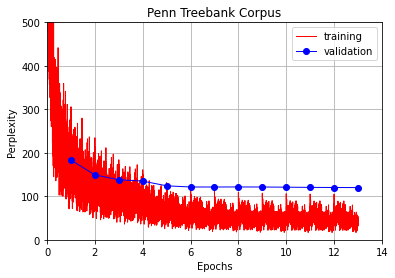

In [38]:
# ------- plot
plt.plot([loss[0] for loss in perplexity_train],
         [loss[1] for loss in perplexity_train],
         linewidth=1,color='red',label='training')
plt.plot([loss[0] for loss in perplexity_valid],
         [loss[1] for loss in perplexity_valid],
         linewidth=1,color='blue',label='validation', marker='o')
plt.grid(True,which='both',axis='both')
plt.title('Penn Treebank Corpus')
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.axis([0,14,0,500])
plt.legend()
plt.show()

In [45]:
# ------------------------ test
session.run(iterator.initializer,
            feed_dict={features_placeholder:data_test.features,
                       labels_placeholder:data_test.labels})
losses_test, y_pred_test=model.run_epoch(session,steps_test,is_training=False) #### added y_pred_test
assert len(losses_test)==steps_test
loss_test_avg=sum(losses_test)/(len(losses_test)*seq_len*batch_size)
print("\nLoss/perplexity on test set after {} epochs: {:8.2f}/{:8.2f}\n".format(
    epoch+1,loss_test_avg,math.exp(loss_test_avg)))
# -------- close the session
# session.close()
# logging.info("execution time - {}s".format(
#     datetime.timedelta(seconds=round(time.time()-start_time))))


Loss/perplexity on test set after 13 epochs:     4.74/  114.27



In [46]:
print(y_pred_test)


Tensor("dense/BiasAdd:0", shape=(20, 20, 10000), dtype=float32)


In [33]:
np.array(y_pred_test)

NotImplementedError: ignored